In [6]:
#Import the tensorflow, numpy and networkx packages.
#I've been thinking about it some more, and decided that using Tensorflow is probably the way to go,
#partly because telling prospective employers you can use it will be more beneficial for you than with AutoGrad,
#and partly because it's built in support for deep networks will make it easier to use in a "graph query is part
#of a deep learning process" setting, which I think will ultimately get you a better grade in the course, and is really
#the most useful usecase for the computational graph query. There's also a LOT more documentation for Tensforflow.
%matplotlib inline
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it

In [2]:
#Define a tensorflow session. Tensorflow getting starting document at:
#https://www.tensorflow.org/get_started/get_started
sess = tf.Session()

In [3]:
#Start building a networkx graph, which seems to handle tensorflow variables ok
#So you can get away with using this for now, I think.
#Create the networkx graph and add a few nodes with various properties.
#Tutorial at https://networkx.readthedocs.io/en/stable/tutorial/tutorial.html
G = nx.DiGraph()
G.add_node(1,time='5pm')
G.add_node(3,color='blue')
X = tf.Variable(5.0)
#Add a second with with the "tfproperty" set to X, where tfproperty is a 
#completely random name I chose.
G.add_node(2, tfproperty = X)
G.add_edge(1,2)
G.add_edge(3,1)
G.add_node(4, tfproperty = tf.constant(3.0))
G.add_edge(1,4,color='green')

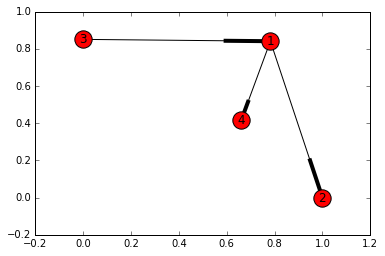

In [4]:
#cost function is X^2, which we want to minimize, so we know we want zero.
cost = (G.node[2]['tfproperty'])**2
#Draw the directed network, where thin to thick indicates an edge from thin to thick (e.g. from 1 to 4)
nx.draw_networkx(G,arrows=True)

In [5]:
#Create optimizer using the Adagrad algorithm with learning_rate 1.0
optimizer = tf.train.AdagradOptimizer(1.0)
train = optimizer.minimize(cost)
#initialise all tensorflow variables and constants.
init = tf.global_variables_initializer()
sess.run(init)

In [6]:
#Run train_steps iterations of the adagrad algorithm.
train_steps=100
cost_tracker = np.zeros([train_steps])
for step in range(train_steps):
    sess.run(train)
    if step%10==0:
        print(step, sess.run(cost))
    cost_tracker[step] = sess.run(cost)

(0, 16.003998)
(10, 1.1895392)
(20, 0.12607139)
(30, 0.01369768)
(40, 0.0014921572)
(50, 0.00016259452)
(60, 1.7717839e-05)
(70, 1.9307095e-06)
(80, 2.1038909e-07)
(90, 2.2926072e-08)


Optimal solution is X=5.58409e-05


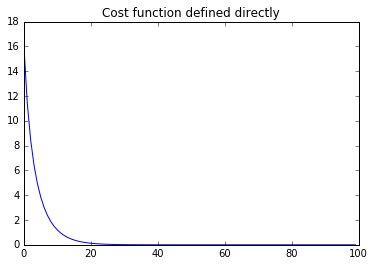

In [7]:
#We see here that this works
plt.plot(cost_tracker)
plt.title("Cost function defined directly")
print("Optimal solution is X="+str(sess.run(X)))

(0, 25.003998)
(10, 10.189539)
(20, 9.126071)
(30, 9.0136976)
(40, 9.0014925)
(50, 9.0001621)
(60, 9.0000181)
(70, 9.0000019)
(80, 9.0)
(90, 9.0)
Optimal solution is X=5.58409e-05


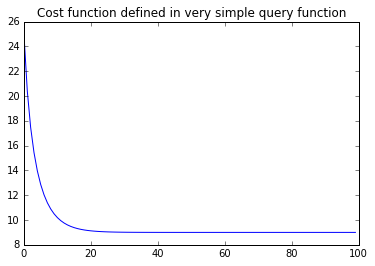

In [9]:
#Above we defined the cost function directly, but we actually want it to be the
#result of a query. Instead, let us say that the objective function is:
#Start at node 1, follow any outbound edges, and return the sum of the square of
#'tfproperty' properties of any such nodes. Naturally, this is still X^2, plus
#a constant of 3.0, since node 4 is fixed, and not variable.
def run_example_query(G):
    #G[i] gives a dictionary of edges outbound from each node, including props.
    #Here we're only interested in the target vertices, so pickup using keys()
    return_value = 0
    #For each edge
    for outbound_edge in G[1].keys():
        #Add the tfproperty of that node
        return_value = return_value+(G.node[outbound_edge]['tfproperty'])**2
    return return_value
cost2 = run_example_query(G)
train2 = optimizer.minimize(cost2)
#reinitialise everything
sess.run(init)
#Now optimize with this form
train_steps=100
cost_tracker2 = np.zeros([train_steps])
for step in range(train_steps):
    sess.run(train)
    if step%10==0:
        print(step, sess.run(cost2))
    cost_tracker2[step] = sess.run(cost2)
plt.plot(cost_tracker2)
plt.title("Cost function defined in very simple query function")
print("Optimal solution is X="+str(sess.run(X)))

In [11]:
#In the above, the query was defined very verbosely as an explicit function.
#The equivalent Gremlin query might be g.V().hasLabel('startNode').
#out().values('tfproperty').squared().sum()
#Or something close to this (I am not a Gremlin expert). In actuality, something
#closer to PGQL http://event.cwi.nl/grades/2016/07-VanRest.pdf is what we'd want
#someone to input a query as, and we'd need to convert that request into the 
#appropriate computational graph. But that's something to potentially think 
#about after the other stuff has been done.

#Anyway, things get a bit tricker when our queries depend on tensorflow values.
#Because we can't actually evaluate any of the tensorflow values until runtime,

#Let's add an extra edge condition in our query to demonstrate this. So it is: 
#"Start at node 1, follow any outbound edges with tfcondition>0.5,
#and return the sum of the square of 'tfproperty' properties of any such nodes."

#Update the graph to have this edge condition between node 1 and node 2,
#and node 1 and node 4.
G.add_edge(1,2,tfcondition=tf.constant(0.6))
G.add_edge(1,4,tfcondition=tf.constant(0.3))


In [15]:
print G[1]

{'tfcondition': <tf.Tensor 'Const_3:0' shape=() dtype=float32>}


In [14]:
# Now we define a new function
def run_example_query2(G):
    #G[i] gives a dictionary of edges outbound from each node, including props.
    #Here we're only interested in the target vertices, so pickup using keys()
    #For each edge
    return_value = tf.constant(0.0)
    for outbound_edge in G[1].keys():
        #If the edge satisfies the condition >0.5, add it, otherwise, don't
        #We can't use a regular if statement, as below, uncomment it to see the problem.
        #if (G[1][outbound_edge]['tfcondition']>0.5):
            #return_value = return_value+(G.node[outbound_edge]['tfproperty'])**2
        #Instead need to use tensorflow specific evaluators. E.g. this is tf.cond(condition,true return, false return)
        def f1(): 
            return return_value+(G.node[outbound_edge]['tfproperty'])**2 
        def f2(): 
            return return_value
        return_value = tf.cond(G[1][outbound_edge]['tfcondition']>0.2,f1,f2)
    return return_value
cost3 = run_example_query2(G)
train3 = optimizer.minimize(cost3)
#reinitialise everything
sess.run(init)
#Now optimize with this form
train_steps=100
cost_tracker3 = np.zeros([train_steps])
for step in range(train_steps):
    sess.run(train)
    if step%10==0:
        print(step, sess.run(cost3))
    cost_tracker2[step] = sess.run(cost3)
plt.plot(cost_tracker2)
plt.title("Cost function defined on more complicated query function")
print("Optimal solution is X="+str(sess.run(X)))

ValueError: Operation u'cond_3/Merge' has been marked as not fetchable.

In [ ]:
# Try experimenting with the weight condition in line 17 (press escape then l in a cell to see line numbers),
#particularly for the case when the condition is small enough to let node 4 be added to the query return.
#Then there's a sudden jump in the cost function from 0 to 9. Now imagine that this weight condition is a variable,
#and we can choose where to set it (then obviously we'd set it so node 4 isn't included). But doing this with gradients
# means that the sudden jump when the edge condition to node 4 crosses 0.5 isn't visible, it's a discontinuity in the
#function. You don't need to worry about this for now, but this is an aspect that I'll be working on.

In [12]:
#Anyway, I hope this helps you understand some aspects of how this is going to work a bit better. For our meeting next
#week, I'd like you to do the following:

#1: Go through this code carefully so you understand what's going on. E.g. how networks are constructed in networkx,
#and how tensorflow is working here. The general tensorflow tutorials on the website I've linked to above might help.
#In addition, try to get a grasp on the general concept of how a computational graph query could work. In the query 
#directly above for example, you can see that this query as defined as a function of tensorflow variables here, and an
#input network G, will work for any network G that has tfcondition and tfproperty on edges and nodes that are neighbors
#of node 1 (we can also use conditions to check if certain properties exist).

#2: Build a more complex network, and a more complex query, based on the tools demonstrated above. In the examples
#above, the nodes, edges and variables didn't have any real meaning, but it should demonstrate the idea of running a
#"query", and optimizing the result of that query. A simple example might be something with a financial flavor,
#if Professor Lin is after something like that. You could have a "social network of companies" (e.g. where edges) 
#indicate that companies work together, collaborate, or otherwise have some sort of transaction that ties them together
#. This could (should for now) be an entirely ficticious network. Anyway, you can give each company an "Expected fraud"
#property on their node. Then you could do something like "How do I allocate my attention to these companies so that I
#am observing where the most fraud is going on". You might have a total "attention budget" of 1, and can allocate
#frations of that budget to get a "weighted observed fraud" value(i.e. 0.5 to company 1, 0.25 to company 2, and 
#0.25 to company 3 would give weighted_observed_fraud=0.5*company_1_expected_fraud+0.25*company_2_expected_fraud+
#0.25*company_3_expected_fraud. The idea is that you want to optimize the weights. The trivial answer here under
#no other constraints is that you allocate all your weight to the company with the highest expected fraud. We'd
#eventually want to add constraints (e.g. you have to invest a certain amount of weight in two particular companies),
#but this will suffice for now, and will tell you when you have the right answer.

#Note that tensflow variables at free by default, meaning they can be from negative infinity to infinity. So the fact
#they are positive and add to 1 IS a set of constraints itself. Fortunately, there is any easy way to deal with this,
#the softmax function https://en.wikipedia.org/wiki/Softmax_function which can be accessed in tensorflow as 
#tf.nn.softmax(vector_of_parameters_you're_trying_to_make_positive_and_add_to_one).

#If you want to do more (though I won't expect you to do these things, given that the above might trip you up as
#you're still becoming used to tensorflow), you can look into how deep networks are implemented in tensorflow to perform
#deep learning, and brainstorm so examples where a query return on a graph might be part of a deep learning procedure.